In [1]:
import numpy as np
import geopandas
from shapely.geometry import Point, MultiPoint, LineString
import pandas as pd
import pint
import time
import math
from datetime import datetime, timedelta
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
ureg = pint.UnitRegistry()

define all filenames to be loaded

In [2]:
# can have all used data in a directory, then simply load all files from that directory
f_mt_all = "../DATA_active/mt_all.xls" # compiled
f_tensors_full = "../DATA_active/mt_2014.xls" # copied and pasted from "All_100_MT_Results.docx" in 2014 Seismic
f_tensors = "../DATA_active/All_MT_latlong_Sets_k_T.txt" # Foulger Consulting provided by Trenton Cladouhos of AltaRock Energy
f_well_dev = "../DATA_active/Deviation_Data.csv" # 2012 well completion
f_oct_flow = "../DATA_active/Flow_Test_10-24-2014.xlsx" # 2014 WHP_Flow
f_nov_flow = "../DATA_active/Flow_Test_11-24-2014.xlsx" # 2014 WHP_Flow
f_log1 = "../DATA_active/Newberry_2014_datalog_1.xlsx" # 2014 WHP_Flow
f_log2 = "../DATA_active/Newberry_2014_datalog_2.xlsx" # 2014 WHP_Flow
f_isti = "../DATA_active/catalog.xls" # 2014 Seismic
f_lbnl = "../DATA_active/LBNL_locations.csv" # converted from txt file in 2014 Seismic

load the files into pandas dataframes

In [3]:
mt_all = pd.read_excel(f_mt_all)
tensors_full = pd.read_excel(f_tensors_full)
tensors = pd.read_table(f_tensors)
well = pd.read_csv(f_well_dev)
oct_flow = pd.read_excel(io=f_oct_flow, sheet_name=0)
nov_flow = pd.read_excel(io=f_nov_flow, sheet_name=0)
log1 = pd.read_excel(f_log1)
log2 = pd.read_excel(f_log2)
isti = pd.read_excel(f_isti)
lbnl = pd.read_csv(f_lbnl)
l = len(tensors)

index the full tensor dataframe by time

In [4]:
tensors_full = tensors_full.rename(columns={'Mo': 'month', 'Hr': 'hour', 'min': 'minute', 'Sec': 'second'})
eq_datetime = pd.to_datetime(tensors_full[['Year', 'month', 'Day', 'hour', 'minute', 'second']])
# tensors_full.index = eq_datetime
tensors_full= tensors_full.assign(datetime=pd.Series(eq_datetime).values)

we drop the PNSN solution by using the source time provided in the Foulger report and reset the index

In [5]:
tensors_full = tensors_full.drop(tensors_full[tensors_full.datetime == '2014-10-12 21:10:23.311'].index)
tensors_full = tensors_full.reset_index(drop=True)

create a datetime series for the decomposed tensors dataframe, using the full tensor dataframe for seconds, and check that the full and decomposed times match

In [6]:
tensors_date = pd.to_datetime(tensors[['Year', 'Month', 'Day']])
tensors_hrmn = pd.to_timedelta(tensors.Time+':00')
tensors_sec = pd.to_timedelta(tensors_full.second, unit='s')
tensors_datetime = tensors_date + tensors_hrmn + tensors_sec
tensors['datetime'] = tensors_datetime
all(tensors.datetime == tensors_full.datetime)

True

operation parameters

In [7]:
pad_elevation = 1770 # * ureg.meter # elevation of well pad (m)
well_head = [well.Northings_m[0], well.Eastings_m[0]] # zero depth lat and lon
pad_lat = 43.726128
pad_lon = -121.315485
injection_md = 4000*.3048 #measured depth where injection begins

### Combining Injection and Earthquake Data

set index to datetime for each dataframe with flow data

In [8]:
oct_flow.index = oct_flow['Date/Time']
nov_flow.index = nov_flow['Date + Time ']
log2.index = log2['Date + Time ']
log1.index = log1['Date + Time']
# oct_flow = oct_flow.rename(columns={'flow rate(gpm)': 'flow_oct'})
# nov_flow = nov_flow.rename(columns={'flow (gpm)': 'flow_nov'})
# log1 = log1.rename(columns={'flow rate(gpm)': 'flow_oct'})

From previous inspection we know log2 has duplicates, so we'll remove these.

In [9]:
log2 = log2.drop_duplicates()

#### Flow Data

We concatenate vertically, dropping any NaN rows, and sort by the datetime index. All data is in gpm, so no conversions are necessary

In [10]:
flow = pd.DataFrame()
flow['flow'] = pd.concat([log1['Corrected UltraSonic (gpm)'].dropna(), oct_flow['flow rate(gpm)'].dropna(), 
                  log2['UltraSonic_Flowrate'].dropna(), nov_flow['flow (gpm)'].dropna()], axis=0, sort=True)

In [11]:
# #another method of combining the flow data, neither was time tested, but the above method is chosen since it is executed in one command
# flow = oct_flow['flow rate(gpm)'].combine_first(log1['Corrected UltraSonic (gpm)'])
# flow = flow.combine_first(nov_flow['flow (gpm)'])
# flow = flow.combine_first(log2['UltraSonic_Flowrate'])

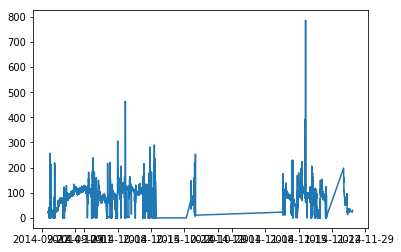

In [12]:
plt.plot(flow)

#### Pressure Data

In [13]:
pressure = pd.DataFrame()
pressure['pressure'] = pd.concat([log1['WHP Corrected  (psi)'].dropna(), log2['WHP Corrected '].dropna()], axis=0)

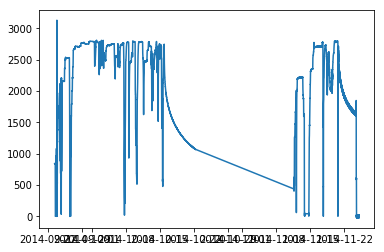

In [14]:
plt.plot(pressure)

#### Temperature Data

In [15]:
temp = pd.DataFrame()
# Comparing log1 and log2 to oct_flow and nov_flow, and considering that the temperature for log1 and log2 is routinely below 32,
# it's assumed that they are incorrectly labeled as being in Fahrenheit. The values for oct_flow are consistent with the Fahrenheit label.
temp['temp'] = pd.concat([log1['WHT (F)'].dropna(), (oct_flow['Blooie line temp (F)'].dropna()-32)*5/9,
                          log2.WHT[log2['WHT']>0].dropna(), nov_flow['Temp C'].dropna()], axis=0)

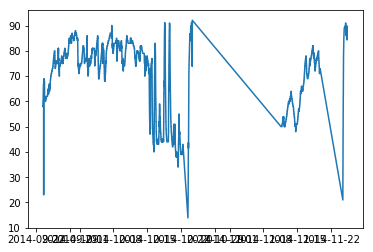

In [16]:
plt.plot(temp)

### Summed Volumetric Release

renaming LBNL columns for creating a datetime column (used for b-value, or for scalar magnitudes if matching LBNL to Foulger events)

In [17]:
# #renaming LBNL columns for creating a datetime column (to compare if can match LBNL to Foulger events)
lbnl = lbnl.rename(columns={'yr': 'year', 'sec': 'second'})
lbnl = lbnl.assign(datetime=pd.to_datetime(lbnl[['year', 'month', 'day', 'hour', 'minute', 'second' ]]))
lbnl.index = lbnl.datetime

In [18]:
# lbnl_date = pd.to_datetime(lbnl[['year', 'month', 'day', 'hour', 'minute', secon]])
# # lbnl.index = lbnl_date + pd.to_timedelta(np.floor(lbnl.second))
# lbnl.index = lbnl_date
# tensors.index = tensors_date + tensors_hrmn # + pd.to_timedelta(np.floor(tensors_full.second))

In [19]:
# tensors_match_floor = tensors.index.intersection(lbnl.index)
# lbnl_match_floor = lbnl.index.intersection(tensors.index)
# len(tensors_match_floor), len(lbnl_match_floor)

In [20]:
# # tensors.drop(tensors_match_floor)
# lbnl_foulger = lbnl.nlargest(l,'magnitude')
# lbnl_foulger = lbnl_foulger.sort_values('datetime')

calculating scalar moment in dyne-cm from Foulger moment magnitudes [need to cite eq]

In [21]:
m_o = 10**(3/2*(tensors.mw + 10.7)) #from old script but need to cite equation
# m_o = m_o.reset_index()

scale every tensor element to Foulger moment for each event

In [22]:
m_2 = tensors_full.iloc[:,0:6]
m_2['EN'] = m_2.NE
m_2['DN'] = m_2.ND
m_2['DE'] = m_2.ED
m_2 = m_2 ** 2
m_o_full = 1/2**(1/2) * m_2.sum(axis=1)**(1/2)
s_full = m_o / m_o_full
t_full_scaled = tensors_full.iloc[:,0:6].mul(s_full, axis=0)

trace of scaled full tensors and sum (haven't implemented decomposition and need to confirm formula choice)

In [23]:
k_full_scaled = t_full_scaled[['NN','EE','DD']].sum(axis=1)
k_full_scaled_sum = sum(k_full_scaled)

In [24]:
# k_test = t_full_scaled[['NN','EE','DD']].sum(axis=1) #**2
# # k_test = k_test.sum(axis=1)**(1/2)
# k_test = k_test / (6**(1/2))
# sum(k_test)

In [25]:
print('total k from scaled full tensors:', k_full_scaled_sum)

total k from scaled full tensors: 2.9779225967007814e+17


total volumentric (isotropic) component of moment release according to Foulger's decomposition

In [56]:
k_scaled = pd.DataFrame()
k_scaled['k_scaled'] = tensors.k*m_o.values #pd.DataFrame({'k_scaled': k_f}, index=tensors.datetime)
k_scaled.index = tensors.datetime
k_scaled['csum'] = k_scaled.k_scaled.cumsum()
k_sum = k_scaled.csum.iloc[-1]

plot of scaled volumetric component (k) given by Foulger decompostition

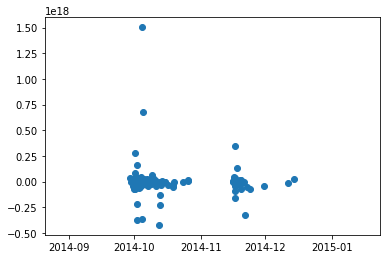

In [57]:
plt.scatter(k_scaled.index,k_scaled.k_scaled)

In [58]:
print('total summed k, Foulger decomposition:', k_sum)

total summed k, Foulger decomposition: 1.4349138571530211e+17


### b-value

In [59]:
l_lbnl = len(lbnl)
num_index = np.linspace(1,l_lbnl,l_lbnl)
N = np.linspace(l_lbnl,1,l_lbnl)
M = lbnl.magnitude.sort_values()
a = np.log10(l_lbnl)

lbnl magnitudes vs number of events equal to or greater than each magnitude (N), logarithmic scale

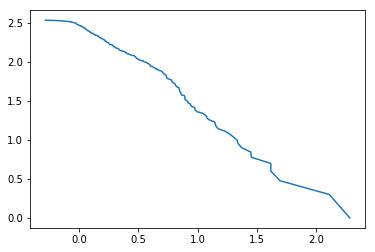

In [60]:
plt.plot(M,np.log10(N))

fitting the line above to get the b-vale from the negative of the slope

In [61]:
b,_ = np.polyfit(M,np.log10(N),1)
# b,_ = np.poly1d(b_fit)
b = -b
print('b-value for entire stimulation:', b)

b-value for entire stimulation: 1.0374701570263183


In [62]:
# M = M.reset_index()
# M.index = N
# M = M.rename(columns={'index':'date_index'})
# M = M.sort_values(by=['date_index'])

fitting the M vs N line at each time step and fititng to get b-value

In [63]:
b_t = np.empty((l_lbnl))
for i in range(l_lbnl):
    b_t[i],_ = -np.polyfit(lbnl.magnitude[0:i+1].sort_values(),np.log10(np.linspace(i+1,1,i+1)),1)
b_t = pd.DataFrame({'b_t': b_t}, index=lbnl.index)

/anaconda/envs/negs_env/lib/python3.6/site-packages/ipykernel/__main__.py:3: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


plot of b-value evolution over time, ignoring b-values from before the first 60 events 

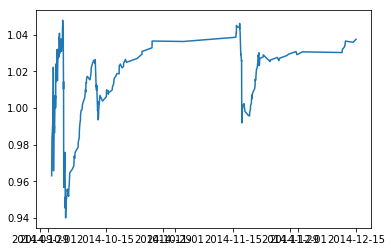

In [64]:
plt.plot(b_t[59:])

adding b_value over time to the lbnl dataset, and converting the depths to meters below surface

In [65]:
lbnl_stats = lbnl.loc[:,['lat', 'lon', 'depth', 'moment']]
lbnl_stats['b'] = b_t
lbnl_stats.depth = lbnl_stats.depth*1000+pad_elevation

### Including Well Path

First put the Foulger locations into a geopandas dataframe, set the projection as WGS84, then re-project to UTM coordinates (zone 10N)

In [66]:
gtensors = tensors.loc[:,['Lat','Long','Depth']]
gtensors.Depth = gtensors.Depth*1e3 + pad_elevation
gtensors['Coordinates'] = list(zip(gtensors.Long,gtensors.Lat, gtensors.Depth))
gtensors['Coordinates'] = gtensors['Coordinates'].apply(Point)
gtensors = geopandas.GeoDataFrame(gtensors, geometry='Coordinates')
gtensors.crs = {'init': 'epsg:4326'}
gtensors = gtensors.to_crs({'init': 'epsg:32610'}) 
tensors.Depth = gtensors.Depth.values

In [67]:
# # take lat, lon for well head and convert to UTM (not necessary since provided in well deviation data)
# pad = pd.DataFrame({'lon': [pad_lat], 'lat': [pad_lon]})
# pad['coordinates'] = list(zip(pad.lat, pad.lon))
# pad.coordinates = pad.coordinates.apply(Point)
# pad = geopandas.GeoDataFrame(pad,geometry='coordinates')
# pad.crs = {'init': 'epsg:4326'}
# pad = pad.to_crs({'init': 'epsg:32610'})

In [68]:
# # (atkat12, Wed Sep 26 2018, GSam11, "Geopandas Dataframe Points to Polygons", Aug 23 '16 at 15:04, https://stackoverflow.com/a/39154164)
# test = gtensors['Coordinates'].apply(lambda x: x.coords[0]) #taking converted coordinates out of GeoDataFrame 

computing convex hull for potential volume estimation

In [69]:
multipoint = MultiPoint(gtensors.Coordinates)
# multipoint
event_shell = multipoint.convex_hull

new dataframe for well path data, convert to m and map to UTM coordinates

In [70]:
gwell = well[['drift_e_ft','drift_n_ft','TVD_ft']]*0.3048
gwell.drift_e_ft = gwell.drift_e_ft+well.Eastings_m[0]
gwell.drift_n_ft = gwell.drift_n_ft+well.Northings_m[0]
well_coord = LineString(gwell.values)

calculating distance from well (need to proof method)

In [71]:
distance = pd.DataFrame()
distance['distance'] = gtensors.Coordinates.distance(well_coord)
distance.index = tensors.datetime

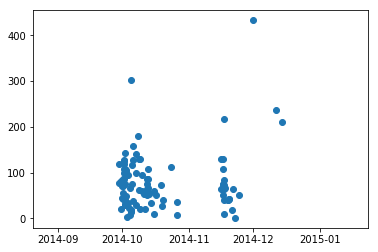

In [72]:
plt.scatter(distance.index, distance)

### Statistical Inquiry

concatenating variables, interpolating the finely sampled data (flow, temperature, pressure) over the event datapoints, and adding 

In [73]:
tensors_stats = tensors.drop(['Year','Number','Month','Day','Time','Set'],axis=1)
tensors_stats.index = tensors_stats.datetime
tensors_stats = pd.concat([flow, pressure, temp, distance, k_scaled, tensors_stats, lbnl_stats], axis=1, sort=True)
tensors_stats.flow.loc[:oct_flow.index[-1]] = tensors_stats.flow.loc[:oct_flow.index[-1]].interpolate(limit_area='inside')
tensors_stats.flow.loc[nov_flow.index[0]:] = tensors_stats.flow.loc[nov_flow.index[0]:].interpolate(limit_area='inside')
tensors_stats.pressure.loc[:oct_flow.index[-1]] = tensors_stats.pressure.loc[:oct_flow.index[-1]].interpolate(limit_area='inside')
tensors_stats.pressure.loc[nov_flow.index[0]:] = tensors_stats.pressure.loc[nov_flow.index[0]:].interpolate(limit_area='inside')
tensors_stats.temp.loc[:oct_flow.index[-1]] = tensors_stats.temp.loc[:oct_flow.index[-1]].interpolate(limit_area='inside')
tensors_stats.temp.loc[nov_flow.index[0]:] = tensors_stats.temp.loc[nov_flow.index[0]:].interpolate(limit_area='inside')
tensors_stats.flow = tensors_stats.flow.fillna(0)
tensors_stats.pressure = tensors_stats.pressure.fillna(0)
tensors_stats.temp = tensors_stats.temp.fillna(0)

/anaconda/envs/negs_env/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


converting datetime to timedelta for easy correllation with other variables

In [74]:
tensors_stats.datetime = pd.to_timedelta(tensors_stats.datetime)
# tensors = tensors.drop(['Year','Number','Month','Day','Time','Set'],axis=1)
tensors_stats.datetime = tensors_stats.datetime - tensors_stats.datetime[~tensors_stats.datetime.isna()][0]
tensors_stats.datetime = tensors_stats.datetime.dt.total_seconds()

creating new columns with the pressure, flow, and b-value at each Foulger datapoint set to the average of their values since the last Foulger datapoint

In [75]:
tensors_stats.k.head()

2014-09-23 10:02:00   NaN
2014-09-23 10:03:00   NaN
2014-09-23 10:04:00   NaN
2014-09-23 10:05:00   NaN
2014-09-23 10:06:00   NaN
Name: k, dtype: float64

In [76]:
#### instead of median over entire range can: fit model acros range, interpolate as before, do moving average, etc, but using a method that incoroporates the values in between events better accounts for the changing trend of the well sampled flow and pressure data
tensors_stats['flow_m'] = pd.Series()
tensors_stats['pressure_m'] = pd.Series()
tensors_stats['bval_m'] = pd.Series()
tensors_stats['temp'] = pd.Series()
index0 = tensors_stats.index[0]
for index in tensors_stats.loc[~tensors_stats.k.isna()].index:
    tensors_stats.loc[index, 'flow_m'] = tensors_stats.loc[index0:index, 'flow'].median()
    tensors_stats.loc[index, 'bval_m'] = tensors_stats.loc[index0:index, 'b'].median()
    tensors_stats.loc[index, 'pressure_m'] = tensors_stats.loc[index0:index, 'pressure'].median()
    tensors_stats.loc[index, 'temp'] = tensors_stats.loc[index0:index, 'temp'].median()
    index0 = index

/anaconda/envs/negs_env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1019: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


using pandas' built in correlation function (Pearson) to calculate correlation matrix

In [77]:
tensors_corr = tensors_stats.drop(['flow', 'pressure', 'temp', 'T'], axis=1).corr()

In [78]:
def granger_multi(matrix):
    rows, cols = matrix.shape[0], matrix.shape[1]
    r = np.ones(shape=(rows, rows))
    p = np.ones(shape=(rows, rows))
    for i in range(rows):
        for j in range(i+1, rows):
            g_ = sm.tsa.stattools.grangercausualitytests(matrix[i], matrix[j])
            g[i, j] = gr[j, i] = g_
#             p[i, j] = p[j, i] = p_
    return g

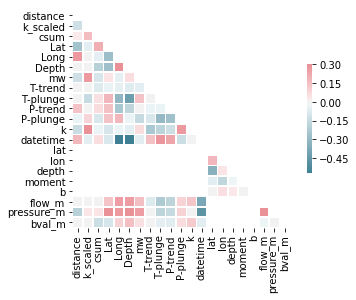

In [79]:
mask = np.zeros_like(tensors_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(tensors_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

using arbitray r value of .5 to filter (will later filter with p-value or time-series specific test) 

In [80]:
corr_threshold = .4
highcorr = tensors_corr[((abs(tensors_corr)>corr_threshold) & (tensors_corr!=1)).any()]
highcorr = highcorr[highcorr.index]

Plot of all variables that had a correlation higher than the cutoff above. The upper half includes linear fits and the lower half includes kernel densite estimation (kde) plots

In [81]:
# g = sns.PairGrid(tensors_stats[highcorr.index].dropna())
# g.map_upper(plt.scatter)
# g.map_diag(sns.distplot)
# # g.map_offdiag(maskfunc)
# g.map_lower(sns.kdeplot)
# g.map_upper(sns.regplot, color=".3")
# # g.map_diag(sns.kdeplot, lw=3, legend=False)

scatter plots and histograms for all variables with correlation above the cutoff

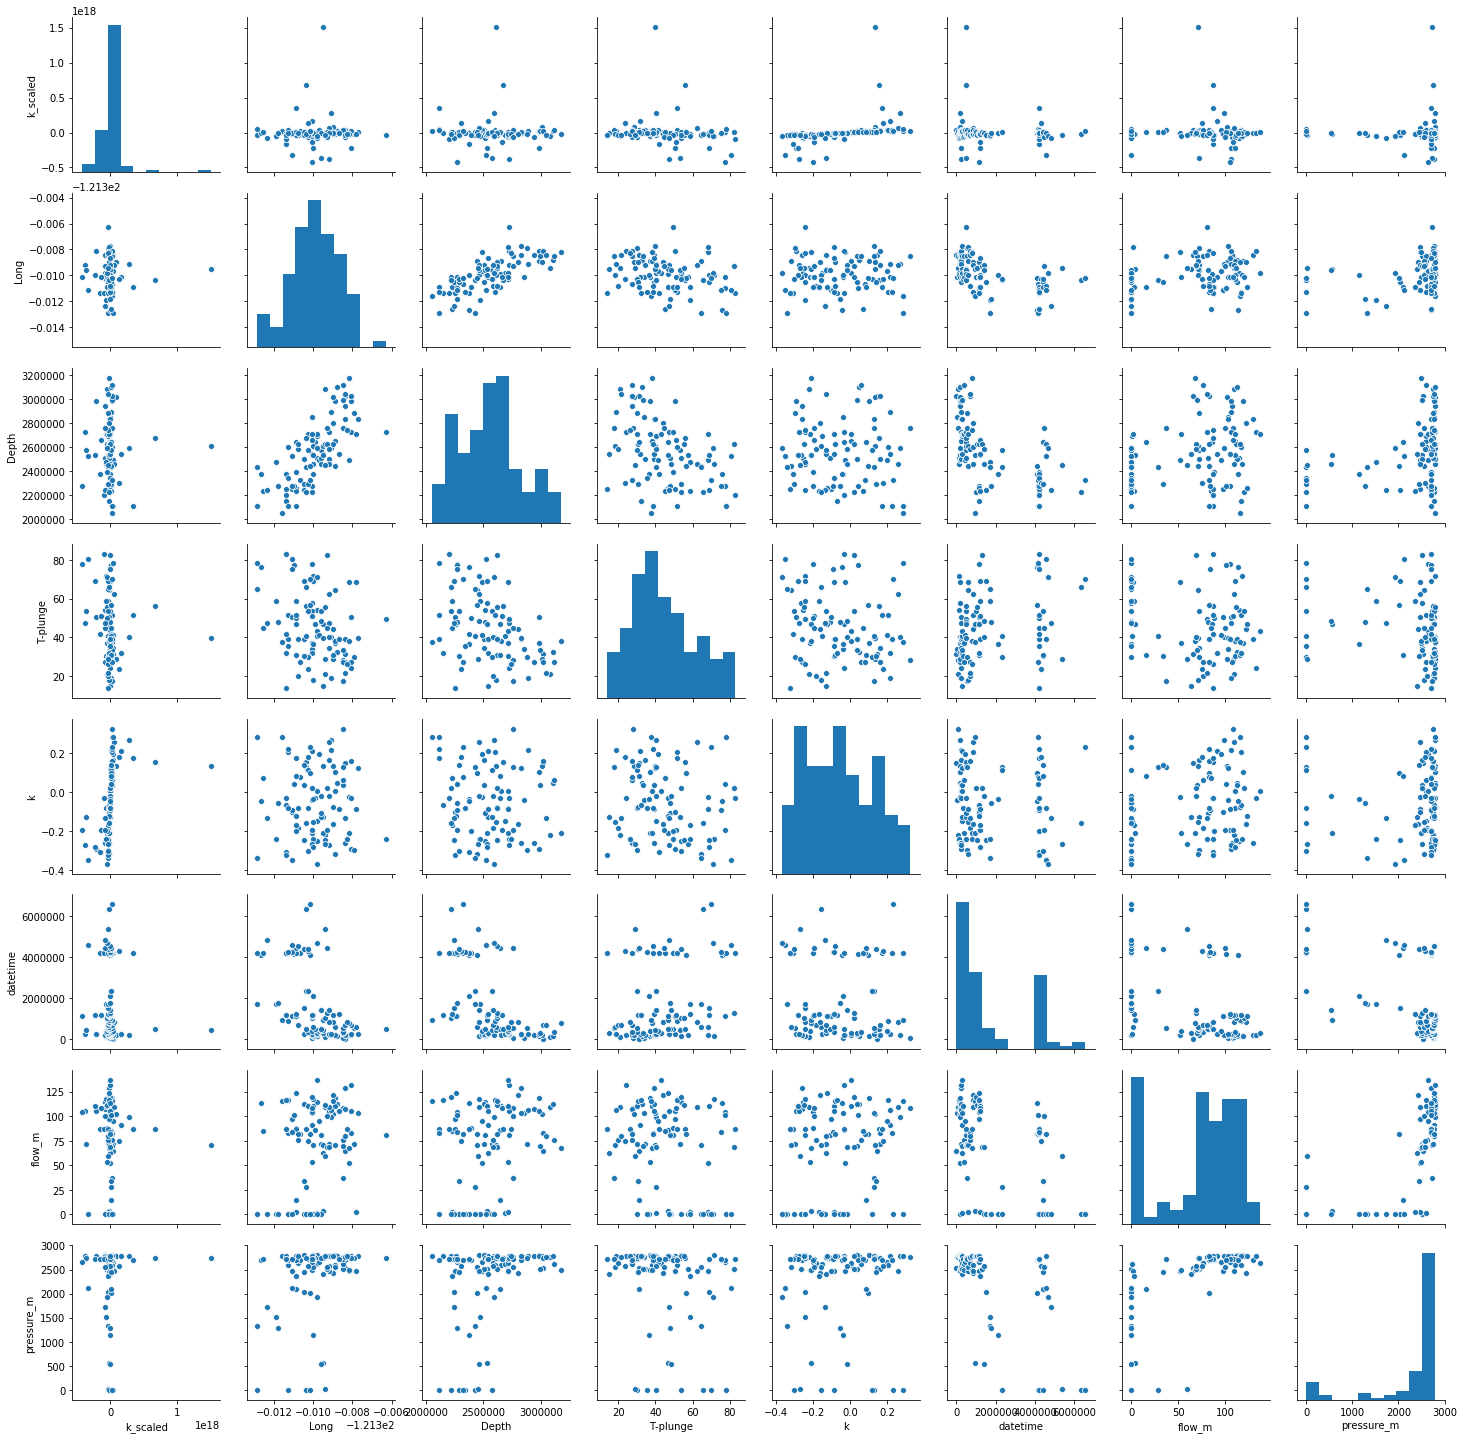

In [82]:
sns.pairplot(tensors_stats[highcorr.index].dropna())

some possible next steps:
* use a statsitical tests approriate for timeseries
* use statiscial methods for multi-variable datasets (such as PCA, FA)
* convert lat, lon to spherical coordinates relative to well at same depth
* calculate estimated "volume" of seismic cloud over time using convex hulls (or other method, also may be redundant with distance from well)
* match LBNL events to Foulger events (manually or algorthmically) to compare magnitudes
* explore the early far field events and their relationships, possible looking for linearity to well